In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/home/mike/work/sdtools")

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.check_rates import *

# from remkit.load import load_remkit
# from code_comparison.code_comparison import *

from cycler import cycler
mpl.rcParams["axes.prop_cycle"] = cycler("color", ["teal", "darkorange", "firebrick", "limegreen", "darkorchid", "deeppink", 
                                                   "#1E90FF", "forestgreen", "#4169e1", "darkgoldenrod", "#9370db", "crimson", "#2f4f4f" ])

sys.path.append(r"/home/mike/work/ReMKiT1D_H3/scripts")
from comp_utils import H3CompFromJSON,H3nTCompPlot,H3qGCompPlot,plotTermsThatEvolveVar

%load_ext autoreload
%autoreload 2

# Intro
- This PR makes sure that processes that depend on collisions get the right ones
- Conduction should only take ee or ii into account
- Diffusion should only take CX and IZ into account
- Neutral viscosity should take CX and IZ 
- Ion viscosity should take ii 

# IO

In [2]:
cs = dict()

db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

toload = [
    dict(name="base", id="dthene-before_closure", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="test", id="full1d-refactor-closure-2025-11-14", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="test-tighttol", id="full1d-refactor-closure-2025-11-14_cvode_tighttol", unnormalise_geom = True, use_xhermes = True, guard_replace = False),

]
#
for case in toload:
    print(f"Loading case {case['name']} from {case['id']}")
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"])
    cs[case["name"]].ds.load()


Loading case base from dthene-before_closure


Text(0.5, 1.0, 'Densities')

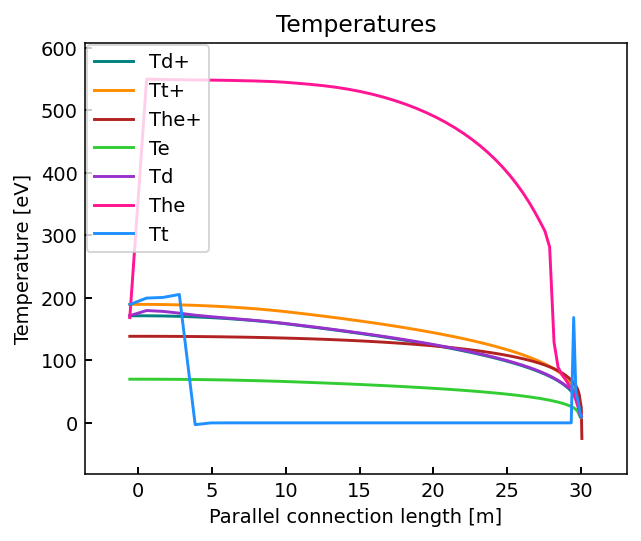

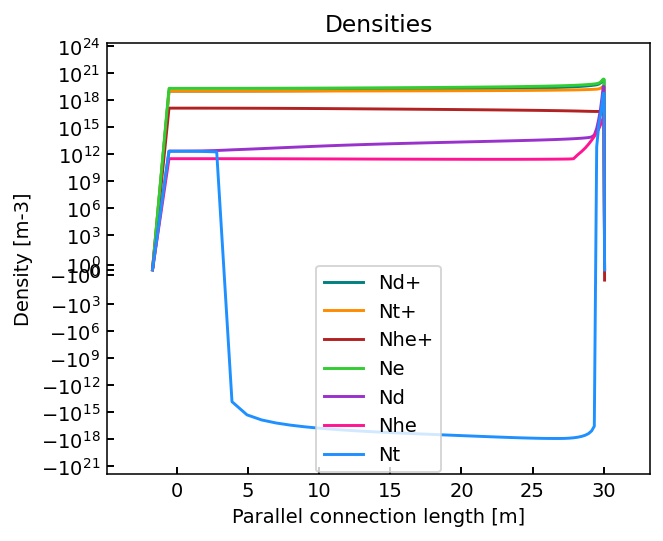

In [21]:
fig, ax = plt.subplots()
for species in ["d+", "t+", "he+", "e", "d", "he", "t"]:
    ds = cs["base"].ds.isel(t=-1)
    ds[f"T{species}"] = ds[f"P{species}"] / ds[f"N{species}"] / constants("q_e")
    ds[f"T{species}"].hermesm.guard_replace_1d().plot(ax = ax, label = f"T{species}")
    
ax.legend()
ax.set_ylabel("Temperature [eV]")
ax.set_title("Temperatures")

fig, ax = plt.subplots()
for species in ["d+", "t+", "he+", "e", "d", "he", "t"]:
    ds = cs["base"].ds.isel(t=-1)
    
    ds[f"N{species}"].hermesm.guard_replace_1d().plot(ax = ax, label = f"N{species}")
    
ax.legend()
ax.set_yscale("symlog")
ax.set_ylabel("Density [m-3]")
ax.set_title("Densities")

In [30]:
%matplotlib widget

KeyError: "No variable named 'ddt(Nt)'. Variables on the dataset include ['Bxy', 'Ed+_iz', 'Ed+_rec', 'Ed+d_coll', 'Ed+d_coll_friction', ..., 'Td+', 'Te', 'Td', 'Tt', 'The']"

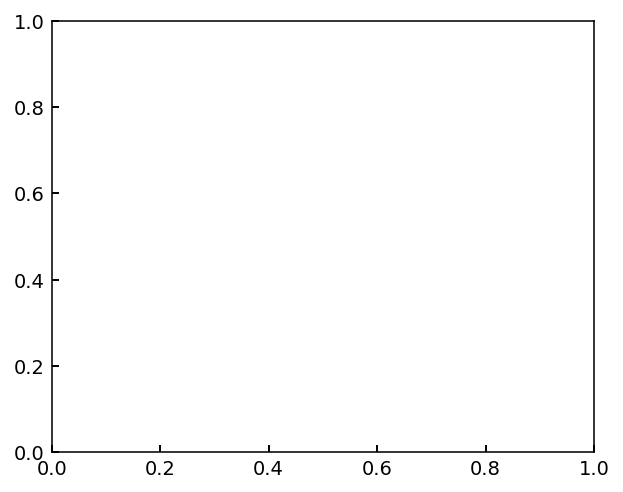

In [40]:
plt.close("all")
ds = cs["base"].ds
fig, ax = plt.subplots()
anim = xbout.plotting.animate.animate_line(ds["ddt(Nt)"].hermesm.guard_replace_1d().squeeze(), ax = ax)
# ax.set_yscale("symlog")
ax.grid()
ax.set_xlim(25, 30.2)

In [28]:
ds["Nt+"].size

54

In [26]:
xbout.plotting.animate.animate_line?

Signature:
xbout.plotting.animate.animate_line(
    data,
    animate_over=None,
    animate=True,
    axis_coords=None,
    vmin=None,
    vmax=None,
    logscale=False,
    fps=10,
    save_as=None,
    sep_pos=None,
    ax=None,
    aspect=None,
    controls='both',
    **kwargs,
)
Docstring:
Plots a line plot which is animated with time.

Currently only supports 1D+1 data, which it plots with animatplot's Line animation.

Parameters
----------
data : xarray.DataArray
animate_over : str, optional
    Dimension over which to animate, defaults to the time dimension
animate : bool, optional
    If set to false, do not create the animation, just return the block
axis_coords : None, str, dict
    Coordinates to use for axis labelling.

    - None: Use the dimension coordinate for each axis, if it exists.
    - "index": Use the integer index values.
    - dict: keys are dimension names, values set axis_coords for each axis
      separately. Values can be: None, "index", the name of a 1d v

In [24]:
xbout.plotting.animate.animate_line(ds["Nt+"])

ValueError: not enough values to unpack (expected 2, got 1)

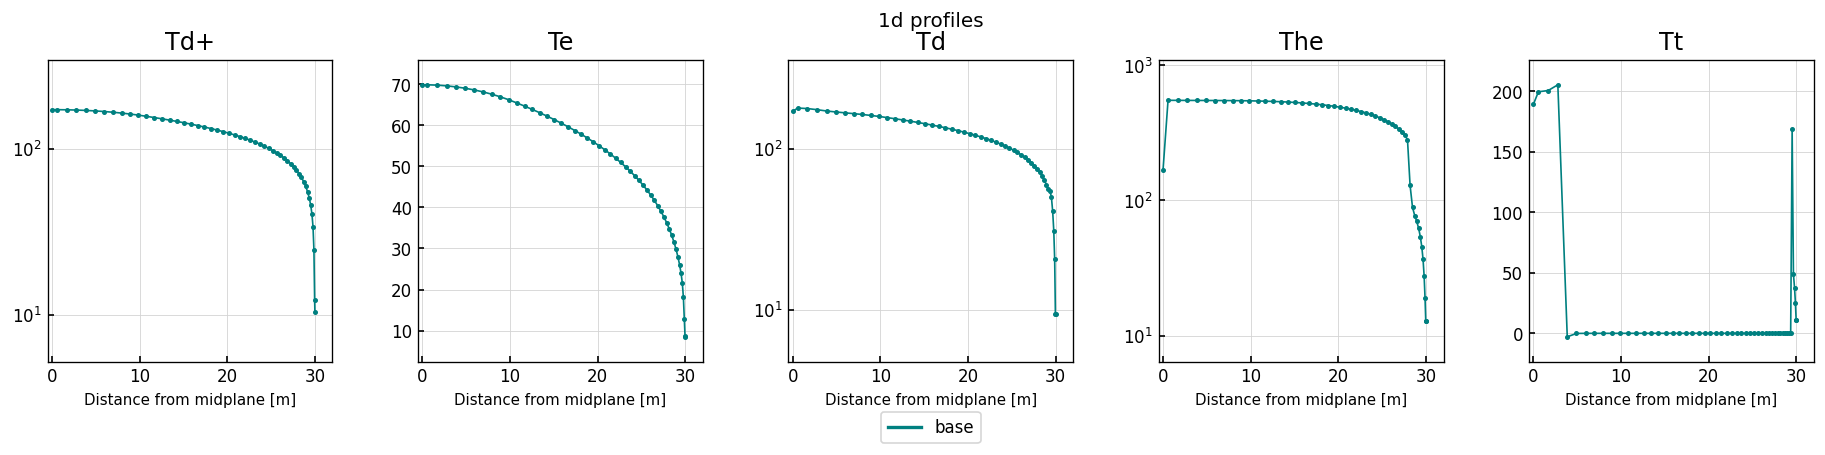

In [ ]:
toplot = {}
for name in cs:
    ds = cs[name].ds
    
    for species in ["d+", "e", "d", "t", "he"]:
        ds[f"T{species}"] = ds[f"P{species}"] / ds[f"N{species}"] / constants("q_e")
        
        
    if "restart" not in name:
        toplot[name] = cs[name].ds.bout.final_time()


lineplot(
    toplot,
    # clean_guards = False,
    guard_replace = True,
    logscale = True,
    params = ["Td+", "Te", "Td", "The", "Tt"],
    params = ["Td+", "Te", "Td", "The", "Tt"],
    # params = ["Vd+"],
    regions = ["1d"],
    lw = 1,
    xlims=(-0.5,32)
    # xlims=(9.8,10.01)
    # xlims = (9.98,10.005),
    # xlims = (29.6, 30.05)
    # xlims=(-0.1,1.5)
)

Text(0, 0.5, 'Td (eV)')

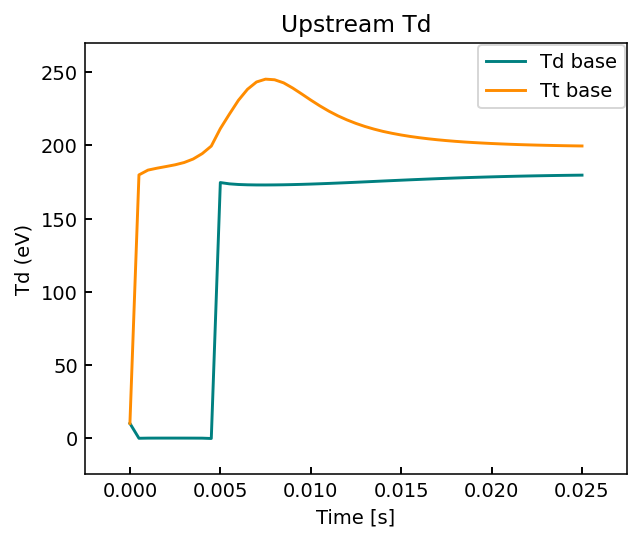

In [4]:
fig, ax = plt.subplots()

for name in cs:
    ds = cs[name].ds
    ds["Td"].isel(pos = 2).plot(ax = ax, label = f"Td {name}")
    ds["Tt"].isel(pos = 2).plot(ax = ax, label = f"Tt {name}")
    
ax.legend()
ax.set_title("Upstream Td")
ax.set_ylabel("Td (eV)")

In [5]:
toplot = {}
for name in cs:
    if name in ["master-new", "refactor-closure-restart"]:
        toplot[name] = cs[name].ds.bout.final_time()

params = [x for x in cs["master-new"].ds.data_vars if x.startswith("K")]

lineplot(
    toplot,
    # clean_guards = False,
    guard_replace = True,
    logscale = True,
    params = params,
    # params = ["Vd+"],
    regions = ["1d"],
    lw = 1,
    # xlims=(9.8,10.01)
    # xlims = (9.98,10.005),
    # xlims = (29.6, 30.05)
    # xlims=(-0.1,1.5)
)

KeyError: 'master-new'